# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Andi Adnan
- **Email:** adnanandi252@gmail.com
- **ID Dicoding:** andi_adnan_252

# **1. Install & Import Modul**

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')
files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install kaggle
!pip install split-folders
!pip install tensorflowjs

In [53]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import splitfolders
import shutil
import subprocess

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# **2. Data Preparation**

## **Data Load**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from kaggle
!kaggle datasets download -d vencerlanz09/plastic-paper-garbage-bag-synthetic-images

# Unzip the dataset
!unzip plastic-paper-garbage-bag-synthetic-images.zip -d "/content/drive/MyDrive/Coding Camp/Modul Project/Belajar Pengembangan Machine Learning/Project-2[Image Classification]"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Coding Camp/Modul Project/Belajar Pengembangan Machine Learning/Project-2[Image Classification]/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010001.jpg  
  inflating: /content/drive/MyDrive/Coding Camp/Modul Project/Belajar Pengembangan Machine Learning/Project-2[Image Classification]/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010002.jpg  
  inflating: /content/drive/MyDrive/Coding Camp/Modul Project/Belajar Pengembangan Machine Learning/Project-2[Image Classification]/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010003.jpg  
  inflating: /content/drive/MyDrive/Coding Camp/Modul Project/Belajar Pengembangan Machine Learning/Project-2[Image Classification]/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010004.jpg  
  inflating: /content/drive/MyDrive/Coding Camp/Modul Project/Belajar Pengembangan Machine Learning/Project-2[Image Classification]/ImageClassesCombinedWithC

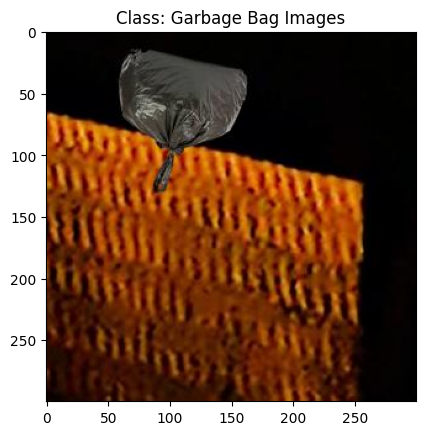

Garbage Bag Images: 5000 images


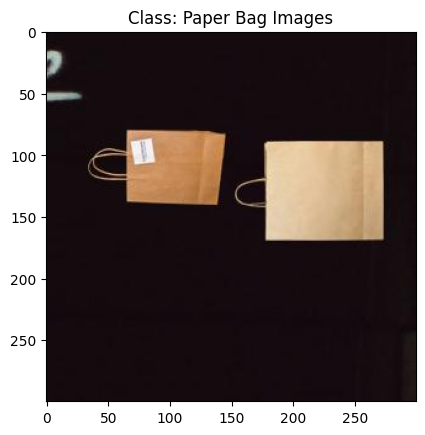

Paper Bag Images: 5000 images


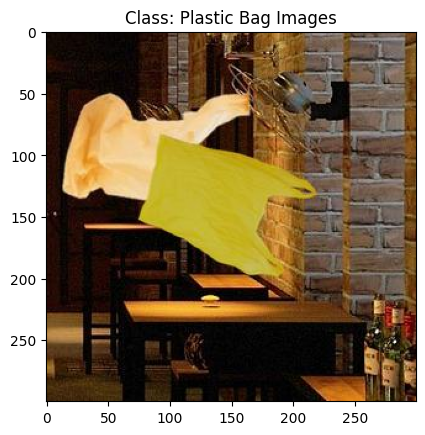

Plastic Bag Images: 5000 images


In [16]:
dataset_path = '/content/drive/MyDrive/Coding Camp/Modul Project/Belajar Pengembangan Machine Learning/Project-2[Image Classification]/Bag Classes/Bag Classes/'

classes = os.listdir(dataset_path)

for cls in classes:
  class_path = os.path.join(dataset_path, cls)
  sample_img = os.listdir(class_path)[0]
  img = mpimg.imread(os.path.join(class_path, sample_img))
  plt.imshow(img)
  plt.title(f"Class: {cls}")
  plt.show()
  print(f"{cls}: {len(os.listdir(class_path))} images")


## **Data Split**
Train : Test : Val = 8 : 1 : 1

In [ ]:
input_folder = "/content/drive/MyDrive/Coding Camp/Modul Project/Belajar Pengembangan Machine Learning/Project-2[Image Classification]/Bag Classes/Bag Classes/"

output_folder = "/content/drive/MyDrive/Coding Camp/Modul Project/Belajar Pengembangan Machine Learning/Project-2[Image Classification]/Bag Classes/dataset-split/"

# Membagi dataset: 80% train, 10% val, 10% test
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .1, .1), move=True)

# **3. Data Preprocessing**

In [5]:
base_dir = '/content/drive/MyDrive/Coding Camp/Modul Project/Belajar Pengembangan Machine Learning/Project-2[Image Classification]/Bag Classes/dataset-split/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parameter untuk image generator
IMG_HEIGHT = 160
IMG_WIDTH = 160
BATCH_SIZE = 64

In [6]:
# Image generator dengan augmentasi yang lebih sederhana
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Image generator tanpa augmentasi untuk validasi dan testing
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
# Membuat generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


# **4. Pembuatan Model**

In [8]:
def create_model():
    model = Sequential([
        # Layer 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D(pool_size=(2, 2)),

        # Layer 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Layer 3
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Flatten dan Dense layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [20]:
# Membuat model
model = create_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,402,179 (20.61 MB)

 Trainable params: 5,402,179 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Callbacks untuk training
checkpoint = ModelCheckpoint(
    'bag_classifier_best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.6977 - loss: 0.7660
Epoch 1: val_accuracy improved from -inf to 0.87364, saving model to bag_classifier_best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.6982 - loss: 0.7649 - val_accuracy: 0.8736 - val_loss: 0.3591
Epoch 2/20
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9062 - loss: 0.3526

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.87364
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9062 - loss: 0.3526 - val_accuracy: 0.8730 - val_loss: 0.3517
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.8717 - loss: 0.3554
Epoch 3: val_accuracy improved from 0.87364 to 0.89878, saving model to bag_classifier_best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 140s 661ms/step - accuracy: 0.8717 - loss: 0.3553 - val_accuracy: 0.8988 - val_loss: 0.3287
Epoch 4/20
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.7812 - loss: 0.3155
Epoch 4: val_accuracy improved from 0.89878 to 0.90014, saving model to bag_classifier_best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7812 - loss: 0.3155 - val_accuracy: 0.9001 - val_loss: 0.3082
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.8892 - loss: 0.3102
Epoch 5: val_accuracy improved from 0.90014 to 0.92935, saving model to bag_classifier_best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 142s 759ms/step - accuracy: 0.8892 - loss: 0.3100 - val_accuracy: 0.9293 - val_loss: 0.1830
Epoch 6/20
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.9375 - loss: 0.1532
Epoch 6: val_accuracy did not improve from 0.92935
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9375 - loss: 0.1532 - val_accuracy: 0.9198 - val_loss: 0.2166
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.9162 - loss: 0.2314
Epoch 7: val_accuracy improved from 0.92935 to 0.94633, saving model to bag_classifier_best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 202s 793ms/step - accuracy: 0.9162 - loss: 0.2313 - val_accuracy: 0.9463 - val_loss: 0.1554
Epoch 8/20
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9062 - loss: 0.4434
Epoch 8: val_accuracy improved from 0.94633 to 0.95041, saving model to bag_classifier_best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9062 - loss: 0.4434 - val_accuracy: 0.9504 - val_loss: 0.1214
Epoch 9/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.9293 - loss: 0.2041
Epoch 9: val_accuracy improved from 0.95041 to 0.95177, saving model to bag_classifier_best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 202s 822ms/step - accuracy: 0.9293 - loss: 0.2041 - val_accuracy: 0.9518 - val_loss: 0.1419
Epoch 10/20
  1/187 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9688 - loss: 0.1207
Epoch 10: val_accuracy did not improve from 0.95177
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9688 - loss: 0.1207 - val_accuracy: 0.9443 - val_loss: 0.1700
Epoch 11/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9383 - loss: 0.1964
Epoch 11: val_accuracy did not improve from 0.95177
187/187 ━━━━━━━━━━━━━━━━━━━━ 202s 851ms/step - accuracy: 0.9383 - loss: 0.1963 - val_accuracy: 0.9443 - val_loss: 0.1794
Epoch 12/20
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.9062 - loss: 0.2603
Epoch 12: val_accuracy did not improve from 0.95177
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9062 - loss: 0.2603 - val_accuracy: 0.9504 - val_loss: 0.1604
Epoch 13/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.9511 - loss: 0.1477
Epoch 13: 

# **5. Evaluasi**

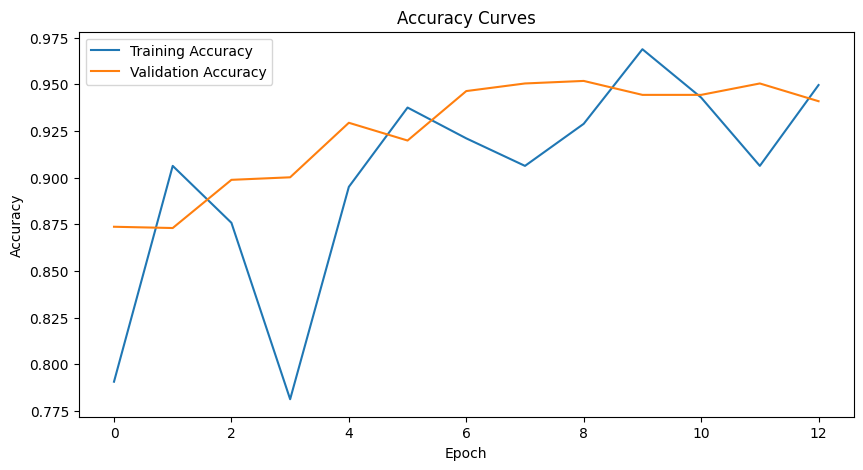

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

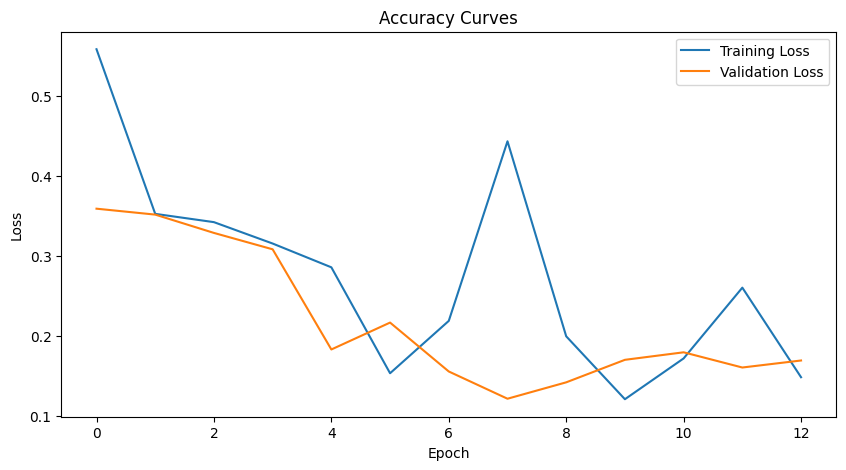

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
model.evaluate(test_generator)
predictions = model.predict(test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 459s 20s/step - accuracy: 0.9759 - loss: 0.0774
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step


In [56]:
y_true = test_generator.classes

y_pred = np.argmax(predictions, axis=1)
print(f"Akurasi: {accuracy_score(y_true, y_pred)}")
print(f"Presisi: {precision_score(y_true, y_pred, average='macro')}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro')}")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

Akurasi: 0.9706666666666667
Presisi: 0.9708421932871106
Recall: 0.9706666666666667
                    precision    recall  f1-score   support

Garbage Bag Images       0.98      0.99      0.98       500
  Paper Bag Images       0.98      0.95      0.97       500
Plastic Bag Images       0.95      0.97      0.96       500

          accuracy                           0.97      1500
         macro avg       0.97      0.97      0.97      1500
      weighted avg       0.97      0.97      0.97      1500



# **6. Save Model**

In [40]:
# Simpan dalam format SavedModel
export_dir = '/content/saved_model'
tf.saved_model.save(model, export_dir)

In [46]:
# Simpan dalam format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TFLite ke dalam direktori 'content'
with open('/content/model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpxqo1hmlo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132222788231504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132222788234192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132222788233616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132222788234960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132222788234384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132222788235728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132222788235152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132222788236496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132222788235920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132222788237264: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [52]:
# Simpan dalam format TFJS
!tensorflowjs_converter \
  --input_format=tf_saved_model \
  --output_format=tfjs_graph_model \
  "/content/saved_model" \
  "/content/tfjs_model"

CompletedProcess(args=['tensorflowjs_converter', '--input_format=tf_saved_model', '--output_format=tfjs_graph_model', '/content/saved_model/', '/content/tfjs_model/'], returncode=0)

In [51]:
shutil.make_archive("/content/tfjs_model", 'zip', "/content/tfjs_model")

'/content/tfjs_model.zip'